In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import casadi as ca
import cyecca.lie as lie
from cyecca.lie.group_so3 import SO3Quat, SO3EulerB321, so3, SO3Dcm, SO3EulerLieGroup
from cyecca.lie.group_se23 import SE23Quat, se23
from scipy.spatial.transform import Rotation

# MCAP/ROS bag reading imports
try:
    import rclpy
    from rclpy.serialization import deserialize_message
    from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
    from nav_msgs.msg import Odometry
    from sensor_msgs.msg import Imu, MagneticField
    MCAP_AVAILABLE = True
    print("MCAP reading libraries available")
except ImportError as e:
    MCAP_AVAILABLE = False
    print(f"MCAP reading libraries not available: {e}")
    print("Please install: pip install ros2bag rosbag2-py")

# Set up plotting
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')  # fallback for older versions
    except:
        pass  # use default style if seaborn not available
plt.rcParams['figure.figsize'] = (12, 8)

MCAP reading libraries available


In [83]:
# Constants
g = 9.8  # gravity acceleration m/s^2

def angle_wrap(angle):
    """Wrap angle to [-pi, pi]"""
    wrapped = ca.fmod(angle, 2 * ca.pi)
    wrapped = ca.if_else(wrapped < 0, wrapped + 2 * ca.pi, wrapped)
    return ca.if_else(wrapped > ca.pi, wrapped - 2 * ca.pi, wrapped)

def quat_to_euler(q):
    """Convert quaternion [w,x,y,z] to Euler angles [roll,pitch,yaw]"""
    r = Rotation.from_quat([q[1], q[2], q[3], q[0]])  # scipy uses [x,y,z,w]
    return r.as_euler('xyz', degrees=True)  # roll, pitch, yaw in degrees

In [84]:
def derive_attitude_estimator_basic():
    """Attitude estimator using magnetometer and accelerometer corrections"""
    # Define Casadi variables
    q0 = ca.SX.sym("q", 4)
    q_wb = SO3Quat.elem(param=q0)
    mag_b = ca.SX.sym("mag", 3)
    mag_decl = ca.SX.sym("mag_decl", 1)
    omega_b = ca.SX.sym("omega_b", 3)
    accel_b = ca.SX.sym("accel", 3)
    accel_gain = ca.SX.sym("accel_gain", 1)
    mag_gain = ca.SX.sym("mag_gain", 1)
    dt = ca.SX.sym("dt", 1)

    # Correction angular velocity vector
    omega_w = ca.SX.zeros(3, 1)

    # --- Magnetometer correction (yaw) ---
    # Transform magnetometer to world frame
    mag_earth = q_wb @ mag_b

    # Magnetometer error calculation
    mag_error_w = -angle_wrap(ca.atan2(mag_earth[1], mag_earth[0]) + mag_decl - ca.pi / 2)

    # Check if magnetometer is not too vertical
    gamma = ca.acos(mag_b[2] / ca.norm_2(mag_b))
    mag_error_w = ca.if_else(ca.sin(gamma) > 0.1, mag_error_w, 0)

    # Apply magnetometer correction
    #omega_w += ca.vertcat(0, 0, mag_error_w) * mag_gain

    # --- Accelerometer correction (roll/pitch) ---
    # Transform acceleration to world frame
    accel_w = q_wb @ accel_b
    accel_norm = ca.norm_2(accel_w)
    accel_w_normed = accel_w / accel_norm
    

    # Only correct if acceleration is close to gravity
    threshold = 0.1
    higher_lim_check = ca.if_else(accel_norm < g * (1 + threshold), 1, 0)
    lower_lim_check = ca.if_else(accel_norm > g * (1 - threshold), 1, 0)
    accel_norm_check = higher_lim_check * lower_lim_check

    # Reduce gain when accelerating
    accel_gain_magnitude = 1 - ca.fabs(((accel_norm - g) / (1.01 * threshold * g)))
    accel_gain_magnitude = ca.if_else(accel_gain_magnitude < 0, 1e-3, accel_gain_magnitude)

    accel_error = ca.cross(ca.vertcat(0, 0, 1), accel_w_normed) 

    # Calculate correction
    accel_correction = (
        ca.vertcat(accel_error[0], accel_error[1], 0)
        * accel_gain
        * accel_norm_check
        * accel_gain_magnitude
    )
    omega_w -= accel_correction

    # Apply correction
    q1 = so3.elem(omega_w * dt).exp(SO3Quat) * q_wb 

    # Return estimator function
    f_att_estimator = ca.Function(
        "attitude_estimator",
        [q0, mag_b, mag_decl, omega_b, accel_b, accel_gain, mag_gain, dt],
        [q1.param, omega_w, accel_norm_check],
        ["q", "mag_b", "mag_decl", "omega_b", "accel_b", "accel_gain", "mag_gain", "dt"],
        ["q1", "q_dot_corr", "accel_norm_check"]
    )

    return f_att_estimator

attitude_estimator_basic = derive_attitude_estimator_basic()

In [85]:
def derive_attitude_estimator_adv():
    """Attitude estimator using magnetometer and accelerometer corrections"""
    # Define Casadi variables
    q0 = ca.SX.sym("q", 4)
    q_wb = SO3Quat.elem(param=q0)
    mag_b = ca.SX.sym("mag", 3)
    mag_decl = ca.SX.sym("mag_decl", 1)
    omega_b = ca.SX.sym("omega_b", 3)
    accel_b = ca.SX.sym("accel", 3)
    accel_gain = ca.SX.sym("accel_gain", 1)
    mag_gain = ca.SX.sym("mag_gain", 1)
    dt = ca.SX.sym("dt", 1)

    # Correction angular velocity vector
    omega_w = ca.SX.zeros(3, 1)
    R = SO3Quat.to_Matrix(q_wb)
    current_roll = ca.atan2(R[2,1], R[2,2])
    current_pitch = ca.atan2(-R[2,0], ca.sqrt(R[2,1]**2 + R[2,2]**2))
    current_yaw = ca.atan2(R[1,0], R[0,0])

    # --- Magnetometer correction (yaw) ---
    # Transform magnetometer to world frame
    mag_earth = q_wb @ mag_b

    # Magnetometer error calculation
    desired_yaw = -angle_wrap(ca.atan2(mag_earth[1], mag_earth[0]) + mag_decl - ca.pi / 2)

    # Check if magnetometer is not too vertical
    gamma = ca.acos(mag_b[2] / ca.norm_2(mag_b))
    desired_yaw = ca.if_else(ca.sin(gamma) > 0.1, desired_yaw, 0)

    # --- Accelerometer correction (roll/pitch) ---
    # Transform acceleration to world frame
    accel_w = q_wb @ accel_b
    accel_norm = ca.norm_2(accel_w)
    accel_w_normed = accel_w / accel_norm
    

    # Only correct if acceleration is close to gravity
    threshold = 0.1
    higher_lim_check = ca.if_else(accel_norm < g * (1 + threshold), 1, 0)
    lower_lim_check = ca.if_else(accel_norm > g * (1 - threshold), 1, 0)
    accel_norm_check = higher_lim_check * lower_lim_check

    # Reduce gain when accelerating
    accel_gain_magnitude = 1 - ca.fabs(((accel_norm - g) / (1.01 * threshold * g)))
    accel_gain_magnitude = ca.if_else(accel_gain_magnitude < 0, 1e-3, accel_gain_magnitude)


    desired_roll = ca.atan2(accel_b[1], accel_b[2])
    desired_pitch = ca.atan2(-accel_b[0], ca.sqrt(accel_b[1]**2 + accel_b[2]**2))

    roll_error = desired_roll - current_roll
    pitch_error = desired_pitch - current_pitch
    yaw_error = desired_yaw - current_yaw

    corrected_roll = current_roll + roll_error * accel_gain * accel_norm_check * accel_gain_magnitude * dt
    corrected_pitch = current_pitch + pitch_error * accel_gain * accel_norm_check * accel_gain_magnitude * dt
    corrected_yaw = current_yaw + yaw_error * mag_gain * dt
    

    euler_corrected = SO3EulerB321.elem(ca.vertcat(current_yaw, corrected_pitch, corrected_roll))
    q1 = SO3Quat.from_Euler(euler_corrected)

    # Return estimator function
    f_att_estimator = ca.Function(
        "attitude_estimator",
        [q0, mag_b, mag_decl, omega_b, accel_b, accel_gain, mag_gain, dt],
        [q1.param,  accel_norm_check],
        ["q", "mag_b", "mag_decl", "omega_b", "accel_b", "accel_gain", "mag_gain", "dt"],
        ["q1", "accel_norm_check"]
    )

    return f_att_estimator

attitude_estimator_adv = derive_attitude_estimator_adv()

In [86]:
def derive_attitude_estimator_IEKF():
    # Define Casadi variables
    q0 = ca.SX.sym("q", 4)
    q_wb = SO3Quat.elem(param=q0)
    mag_b = ca.SX.sym("mag", 3)
    mag_decl = ca.SX.sym("mag_decl", 1)
    omega_b = ca.SX.sym("omega_b", 3)
    accel_b = ca.SX.sym("accel", 3)
    accel_gain = ca.SX.sym("accel_gain", 1)
    mag_gain = ca.SX.sym("mag_gain", 1)
    dt = ca.SX.sym("dt", 1)
    P = ca.SX.sym("P", 3, 3)

    # Note:
    # Magnetometer frame: x is east, y is north, z is up
    # Body frame: x is forward, y is left, z is down
    # World frame: x is east, y is north, z is up

    # Correction angular velocity vector
    error_w = ca.SX.zeros(3, 1)

    # # --- Correction from magnetometer (yaw) ---

    # Transform magnetometer to world frame
    mag_earth = q_wb @ mag_b

    # Magnetometer error calculation
    mag_error_w = -angle_wrap(ca.atan2(mag_earth[1], mag_earth[0]) + mag_decl - ca.pi / 2) # the magnetic north is at (90 degrees - mag_decl) yaw

    # mag check
    gamma = ca.acos(mag_b[2] / ca.norm_2(mag_b))  # angle from vertical
    mag_error_check = ca.if_else(ca.sin(gamma) > 0.1, 0, 1)

    error_w += (ca.vertcat(0,0,mag_error_w))

    # # --- Correction from accelerometer (roll/pitch) ---

    # Transform acceleration in world frame
    accel_w = q_wb @ accel_b 
    accel_norm = ca.norm_2(accel_w)
    accel_w_normed = accel_w / accel_norm

    # Correct accelerometer only if g between 0.9g and 1.1g
    threshold = 0.05
    higher_lim_check = ca.if_else(ca.fabs(accel_w_normed[2]) < (1 + threshold), 0, 1) * ca.if_else(accel_norm < g * (1 + threshold), 0, 1)
    lower_lim_check = ca.if_else(ca.fabs(accel_w_normed[2]) > (1 - threshold), 0, 1) * ca.if_else(accel_norm > g * (1 - threshold), 0, 1)
    accel_norm_check = higher_lim_check * lower_lim_check

    # Acceleration gain
    # If the drone is accelerating, we shouldn't trust the accelerometer
    accel_gain_magnitude = 1 - ca.fabs(((accel_norm - g) / (1.01 * threshold * g)))
    accel_gain_magnitude = ca.if_else(accel_gain_magnitude < 0, 1e-3, accel_gain_magnitude)
    
    # Correct gravity as z
    error_w -= (
        ca.cross(ca.vertcat(0,0,1), ca.vertcat(accel_w_normed[0],accel_w_normed[1],accel_w_normed[2]))
    )

    ## TODO add gyro bias stuff

    pitch_cov = 1e-1
    roll_cov = 1e-1
    yaw_cov = 1e-1
    
    L = ca.SX.zeros(3, 3)
    L[0,0] = pitch_cov / (accel_gain_magnitude * accel_gain) + 1e4 * accel_norm_check
    L[1,1] = roll_cov / (accel_gain_magnitude * accel_gain) + 1e4 * accel_norm_check
    L[2,2] = yaw_cov / (mag_gain) + 1e4 * mag_error_check
    Q = ca.SX.eye(3) * 1e-6

    # --- IEKF ---
    R = SO3Dcm.from_Quat(q_wb).to_Matrix()
    # Predict covariance
    F = so3.wedge(omega_b * dt).exp(SO3Dcm).to_Matrix()
    P_new = F @ P @ F.T + Q

    # Kalman Gain calculation
    H = ca.SX.eye(3)
    S = H @ P_new @ H.T + L
    K = P_new @ H.T @ ca.inv(S)

    # Correction
    correction_w = K @ error_w

    # Add saturation to prevent large jumps
    max_correction = 0.1  # radians, tune this value
    correction_norm = ca.norm_2(correction_w)
    correction_w = ca.if_else(
        correction_norm > max_correction,
        correction_w * max_correction / correction_norm,
        correction_w
    )

    q1 = so3.wedge(correction_w * dt).exp(SO3Quat) * q_wb

    # Return estimator
    f_att_estimator = ca.Function(
        "attitude_estimator",
        [
            q0,
            mag_b,
            mag_decl,
            omega_b,
            accel_b,
            accel_gain,
            mag_gain,
            dt,
            P,
        ],
        [q1.param, P_new],
        [
            "q",
            "mag_b",
            "mag_decl",
            "omega_b",
            "accel_b",
            "accel_gain",
            "mag_gain",
            "dt",
            "P",
        ],
        ["q1", "P_new"],
    )

    return f_att_estimator

attitude_estimator_IEKF = derive_attitude_estimator_IEKF()

In [87]:
def derive_attitude_estimator_PX4() -> ca.Function:
    """Builds a CasADi function implementing PX4-style attitude corrections (mag + accel).

    This function computes attitude corrections using magnetometer and accelerometer
    following the PX4 AttitudeEstimatorQ logic, excluding gyro integration (assumed
    handled elsewhere). The quaternion is updated using only the correction term.

    Args:
        None

    Returns:
        casadi.Function: A function with signature:
            attitude_estimator(q, mag_b, mag_decl, omega_b, accel_b, accel_gain, mag_gain, dt) -> q1

            - q (4x1): Quaternion [qw, qx, qy, qz]
            - mag_b (3x1): Magnetometer measurement in body frame
            - mag_decl (1x1): Magnetic declination (rad)
            - omega_b (3x1): Body angular rate for spin-gain scheduling (rad/s)
            - accel_b (3x1): Accelerometer measurement in body frame (m/s^2)
            - accel_gain (1x1): Accelerometer correction gain
            - mag_gain (1x1): Magnetometer correction gain
            - dt (1x1): Timestep for applying the correction (s)

            - q1 (4x1): Corrected and normalized quaternion
    """

    def normalize_quat(q: ca.SX) -> ca.SX:
        norm_q = ca.norm_2(q)
        return q / (norm_q + 1e-12)

    def normalize_vec(v: ca.SX) -> ca.SX:
        n = ca.norm_2(v)
        return v / (n + 1e-12)

    def wrap_pi(angle: ca.SX) -> ca.SX:
        # Numerically robust wrap using atan2(sin, cos)
        return ca.atan2(ca.sin(angle), ca.cos(angle))

    def quat_to_rotmat(q: ca.SX) -> ca.SX:
        # q = [qw, qx, qy, qz]
        qw, qx, qy, qz = q[0], q[1], q[2], q[3]

        # Rotation matrix corresponding to quaternion (body -> earth)
        # Matches conventional Hamiltonian quaternion with qw as scalar part
        r00 = 1 - 2 * (qy * qy + qz * qz)
        r01 = 2 * (qx * qy - qz * qw)
        r02 = 2 * (qx * qz + qy * qw)

        r10 = 2 * (qx * qy + qz * qw)
        r11 = 1 - 2 * (qx * qx + qz * qz)
        r12 = 2 * (qy * qz - qx * qw)

        r20 = 2 * (qx * qz - qy * qw)
        r21 = 2 * (qy * qz + qx * qw)
        r22 = 1 - 2 * (qx * qx + qy * qy)

        return ca.vertcat(
            ca.horzcat(r00, r01, r02),
            ca.horzcat(r10, r11, r12),
            ca.horzcat(r20, r21, r22),
        )

    def quat_omega_dot(q: ca.SX, omega_b: ca.SX) -> ca.SX:
        # q_dot = 0.5 * q ⊗ [0, omega]
        qw, qx, qy, qz = q[0], q[1], q[2], q[3]
        ox, oy, oz = omega_b[0], omega_b[1], omega_b[2]
        r0, r1, r2, r3 = 0, ox, oy, oz

        dq0 = qw * r0 - qx * r1 - qy * r2 - qz * r3
        dq1 = qw * r1 + qx * r0 + qy * r3 - qz * r2
        dq2 = qw * r2 - qx * r3 + qy * r0 + qz * r1
        dq3 = qw * r3 + qx * r2 - qy * r1 + qz * r0

        return 0.5 * ca.vertcat(dq0, dq1, dq2, dq3)

    # Symbols
    q = ca.SX.sym("q", 4)
    mag_b = ca.SX.sym("mag_b", 3)
    mag_decl = ca.SX.sym("mag_decl", 1)
    omega_b = ca.SX.sym("omega_b", 3)
    accel_b = ca.SX.sym("accel_b", 3)
    accel_gain = ca.SX.sym("accel_gain", 1)
    mag_gain = ca.SX.sym("mag_gain", 1)
    dt = ca.SX.sym("dt", 1)

    # Normalize quaternion first (matches PX4 normalization behavior)
    qn = normalize_quat(q)

    accel_b_minus = -accel_b

    # Compute spin rate for magnetometer gain scheduling
    # spin_rate = ca.norm_2(omega_b)
    # fifty_dps = 0.873  # ~50 deg/s in rad/s
    # gain_mult = ca.if_else(
    #     spin_rate > fifty_dps,
    #     ca.fmin(spin_rate / fifty_dps, 10.0),
    #     1.0,
    # )

    # Rotation: body -> earth
    R_be = quat_to_rotmat(qn)

    # Magnetometer correction (project mag to earth XY and compute heading error)
    mag_earth = R_be @ mag_b
    mag_err = -wrap_pi(ca.atan2(mag_earth[1], mag_earth[0]) + mag_decl + ca.pi / 2)

    # Project magnetometer correction vector [0, 0, -mag_err] (earth) to body frame
    z_err_earth = ca.vertcat(0.0, 0.0, -mag_err)
    # rotateVectorInverse is R_eb = R_be.T
    corr_mag = (R_be.T @ z_err_earth) * (mag_gain)

    # Accelerometer correction
    # Optimized k = R_eb * e_z using PX4 closed-form, where q = [qw, qx, qy, qz]
    qw, qx, qy, qz = qn[0], qn[1], qn[2], qn[3]
    k = ca.vertcat(
        2.0 * (qx * qz - qw * qy),
        2.0 * (qy * qz + qw * qx),
        (qw * qw - qx * qx - qy * qy + qz * qz),
    )

    #k = R_be.T @ ca.vertcat(0.0, 0.0, 1.0)

    # Apply 1g gating like PX4 (without GPS accel compensation)
    one_g = 9.80665
    upper = one_g * 1.1
    lower = one_g * 0.9
    accel_norm_sq = ca.dot(accel_b_minus, accel_b_minus)

    # accel_unit = (_accel - _pos_acc).normalized() with _pos_acc = 0
    accel_unit = normalize_vec(accel_b_minus)

    corr_acc_base = ca.cross(k, accel_unit) * accel_gain
    use_acc = ca.logic_and(accel_norm_sq > (lower * lower), accel_norm_sq < (upper * upper))
    corr_acc = ca.if_else(use_acc, corr_acc_base, ca.DM.zeros(3, 1))
    corr_acc = ca.vertcat(corr_acc[0], corr_acc[1], 0)

    # Total correction angular rate
    corr = corr_acc
    
    # Apply correction only (integrate correction to quaternion)
    q_dot_corr = quat_omega_dot(qn, corr)
    q1 = normalize_quat(qn + q_dot_corr * dt)

    f_att_estimator = ca.Function(
        "attitude_estimator",
        [q, mag_b, mag_decl, omega_b, accel_b, accel_gain, mag_gain, dt],
        [q1, corr],
        ["q", "mag_b", "mag_decl", "omega_b", "accel_b", "accel_gain", "mag_gain", "corr"],
        ["q1", "q_dot_corr"],
    )

    return f_att_estimator

attitude_estimator_PX4 = derive_attitude_estimator_PX4()


In [88]:

# Estimator parameters
ACCEL_GAIN = 0.2  # Accelerometer correction gain
MAG_GAIN = 0.2       # Magnetometer correction gain
MAG_DECLINATION = -4.494167/180 * np.pi     # Magnetic declination (rad)

In [89]:
estimator_type = attitude_estimator_basic
#estimator_type = attitude_estimator_adv

In [90]:

def derive_g_from_euler():
    yaw = ca.SX.sym("yaw")
    pitch = ca.SX.sym("pitch")
    roll = ca.SX.sym("roll")
    euler_angles = ca.vertcat(yaw, pitch, roll)
    euler_element = SO3EulerB321.elem(euler_angles)
    q = SO3Quat.from_Euler(euler_element)
    g = q.inverse() @ ca.vertcat(0, 0, 9.81)
    f_g_from_euler = ca.Function("g_from_euler", [yaw, pitch, roll], [g], ["yaw", "pitch", "roll"], ["g"])
    return f_g_from_euler

g_from_euler = derive_g_from_euler()

print(g_from_euler(0, 0, 0))
print(g_from_euler(0, 0, np.pi/4)) # 45 degrees roll
print(g_from_euler(0, 0, -np.pi/4)) # -45 degrees roll
print(g_from_euler(0, np.pi/4, 0)) # 45 degrees pitch
print(g_from_euler(0, -np.pi/4, 0)) # -45 degrees pitch
print(g_from_euler(np.pi/4, 0, 0)) # 45 degrees yaw
print(g_from_euler(-np.pi/4, 0, 0)) # -45 degrees yaw
print(g_from_euler(0, np.pi/4, np.pi/4)) # 45 degrees roll and 45 degrees pitch
print(g_from_euler(0, -np.pi/4, -np.pi/4)) # -45 degrees roll and -45 degrees pitch
print(g_from_euler(0, -np.pi/4, np.pi/4)) # 45 degrees roll and -45 degrees pitch
print(g_from_euler(0, np.pi/4, -np.pi/4)) # -45 degrees roll and 45 degrees pitch



[0, 0, 9.81]
[0, 6.93672, 6.93672]
[-0, -6.93672, 6.93672]
[-6.93672, 0, 6.93672]
[6.93672, 0, 6.93672]
[0, 0, 9.81]
[-0, 0, 9.81]
[-6.93672, 4.905, 4.905]
[6.93672, -4.905, 4.905]
[6.93672, 4.905, 4.905]
[-6.93672, -4.905, 4.905]


In [91]:
# Test configuration
TEST_DURATION = 25.0  # seconds
TEST_FREQUENCY = 100  # Hz
dt = 1.0 / TEST_FREQUENCY

USE_IEKF = False

true_yaw = 0.0 * np.pi / 180.0      # degrees
true_pitch = -45.0 * np.pi / 180.0  # degrees  
true_roll = 45.0 * np.pi / 180.0    # degrees

CONSTANT_ACCEL = g_from_euler(true_yaw, true_pitch, true_roll)

CONSTANT_MAG = np.array([0.0, 0.0, 0.0])
CONSTANT_GYRO = np.array([0.0, 0.0, 0.0])

# Initial conditions
initial_quat = np.array([1.0, 0.0, 0.0, 0.0])  # Identity quaternion (no rotation)
initial_quat = initial_quat / np.linalg.norm(initial_quat)

# Storage arrays
timestamps = []
attitudes = []   


P_att = np.eye(3, dtype=float) * 0.1

# Initialize attitude
current_quat = initial_quat.copy()

# Generate test data
num_samples = int(TEST_DURATION * TEST_FREQUENCY)
for i in range(num_samples):
    timestamp = i * dt
    
    # Apply attitude estimator with constant measurements
    if USE_IEKF:
        result = attitude_estimator_IEKF(
            current_quat,
            CONSTANT_MAG,
            MAG_DECLINATION,
            CONSTANT_GYRO,
            CONSTANT_ACCEL,
            ACCEL_GAIN,
            MAG_GAIN,
            dt,
            P_att
        )
        P_att = np.array(result[1]).reshape(3, 3)
    else:
        result = estimator_type(
            current_quat,
            CONSTANT_MAG,
            MAG_DECLINATION,
            CONSTANT_GYRO,
            CONSTANT_ACCEL,
            ACCEL_GAIN,
            MAG_GAIN,
            dt
        )

    # Get corrected quaternion and correction vector
    q_corrected = np.array(result[0]).flatten()
    q_corrected = q_corrected / np.linalg.norm(q_corrected)

    # Store results
    timestamps.append(timestamp)
    attitudes.append(q_corrected.copy())
    
    # Update current quaternion for next iteration
    current_quat = q_corrected
    
    # # Progress reporting
    # if i % (TEST_FREQUENCY // 2) == 0:  # Every 0.5 seconds
    #     euler = quat_to_euler(q_corrected)
    #     print(f"t={timestamp:4.1f}s:")
    #     print(f"  Attitude:  Roll={euler[0]:6.1f}°, Pitch={euler[1]:6.1f}°, Yaw={euler[2]:6.1f}°")

print("\nAttitude estimation test complete!")

# Convert results to arrays for analysis
time_array = np.array(timestamps)
attitudes_array = np.array(attitudes)
# Convert quaternions to Euler angles for plotting
euler = np.array([quat_to_euler(q) for q in attitudes])



Attitude estimation test complete!


In [92]:
# Calculate true attitude (expected final attitude based on constant accelerometer reading)


print(f"Expected true attitude: Roll={true_roll}°, Pitch={true_pitch}°, Yaw={true_yaw}°")

# Create arrays of true attitude (constant for all time points)
true_euler = np.array([
    np.full(len(time_array), true_roll / np.pi * 180.0),   # Roll
    np.full(len(time_array), true_pitch / np.pi * 180.0),  # Pitch
    np.full(len(time_array), true_yaw / np.pi * 180.0)     # Yaw
]).T

# Calculate errors (estimated - true)
error_after = euler - true_euler

# Handle angle wrapping for yaw errors (wrap to [-180, 180])
def wrap_angle_degrees(angles):
    """Wrap angles to [-180, 180] degrees"""
    return np.mod(angles + 180, 360) - 180

# Wrap yaw errors
error_after[:, 2] = wrap_angle_degrees(error_after[:, 2])


# Calculate clean statistics
labels = ['Roll', 'Pitch', 'Yaw']

print("=== ATTITUDE ESTIMATION ERROR STATISTICS ===")
print("\\nAfter Correction (Clean Data):")
for i, label in enumerate(labels):
    mean_error = np.mean(error_after[:, i])
    std_error = np.std(error_after[:, i])
    rms_error = np.sqrt(np.mean(error_after[:, i]**2))
    print(f"  {label:5}: Mean = {mean_error:6.2f}°, Std = {std_error:6.2f}°, RMS = {rms_error:6.2f}°")


Expected true attitude: Roll=0.7853981633974483°, Pitch=-0.7853981633974483°, Yaw=0.0°
=== ATTITUDE ESTIMATION ERROR STATISTICS ===
\nAfter Correction (Clean Data):
  Roll : Mean = -11.53°, Std =  12.23°, RMS =  16.81°
  Pitch: Mean =   8.83°, Std =  11.25°, RMS =  14.30°
  Yaw  : Mean = -12.74°, Std =   6.28°, RMS =  14.20°


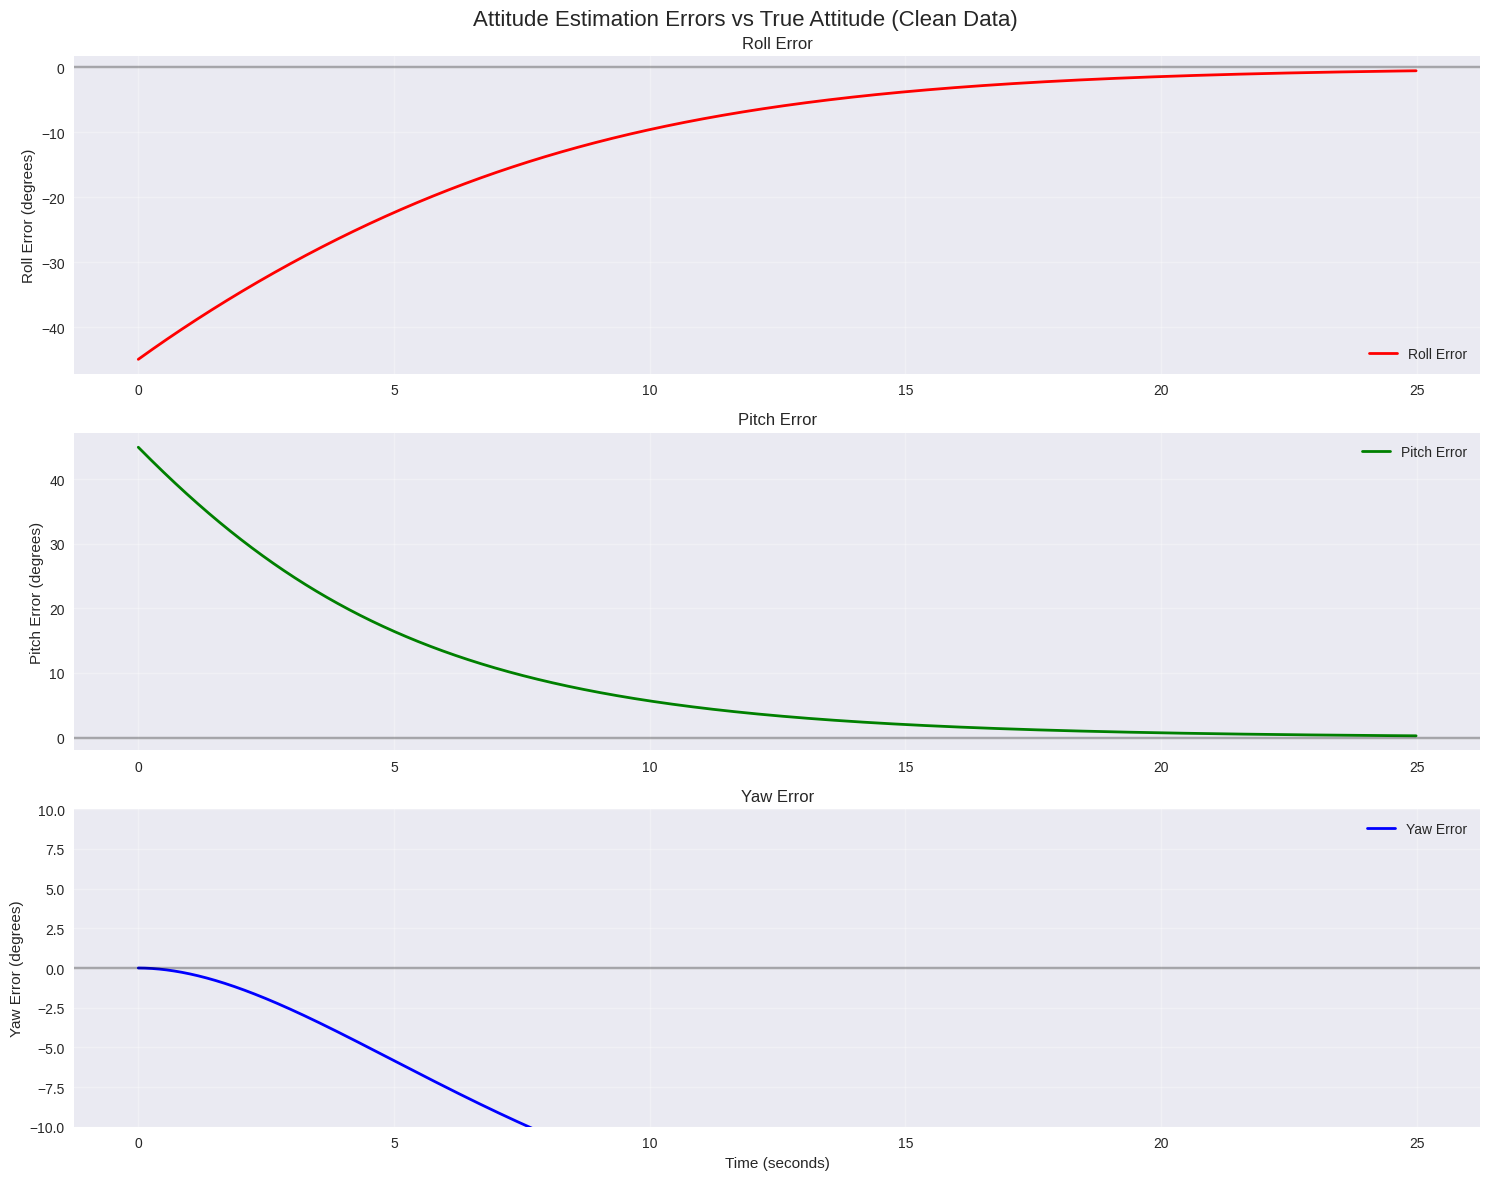

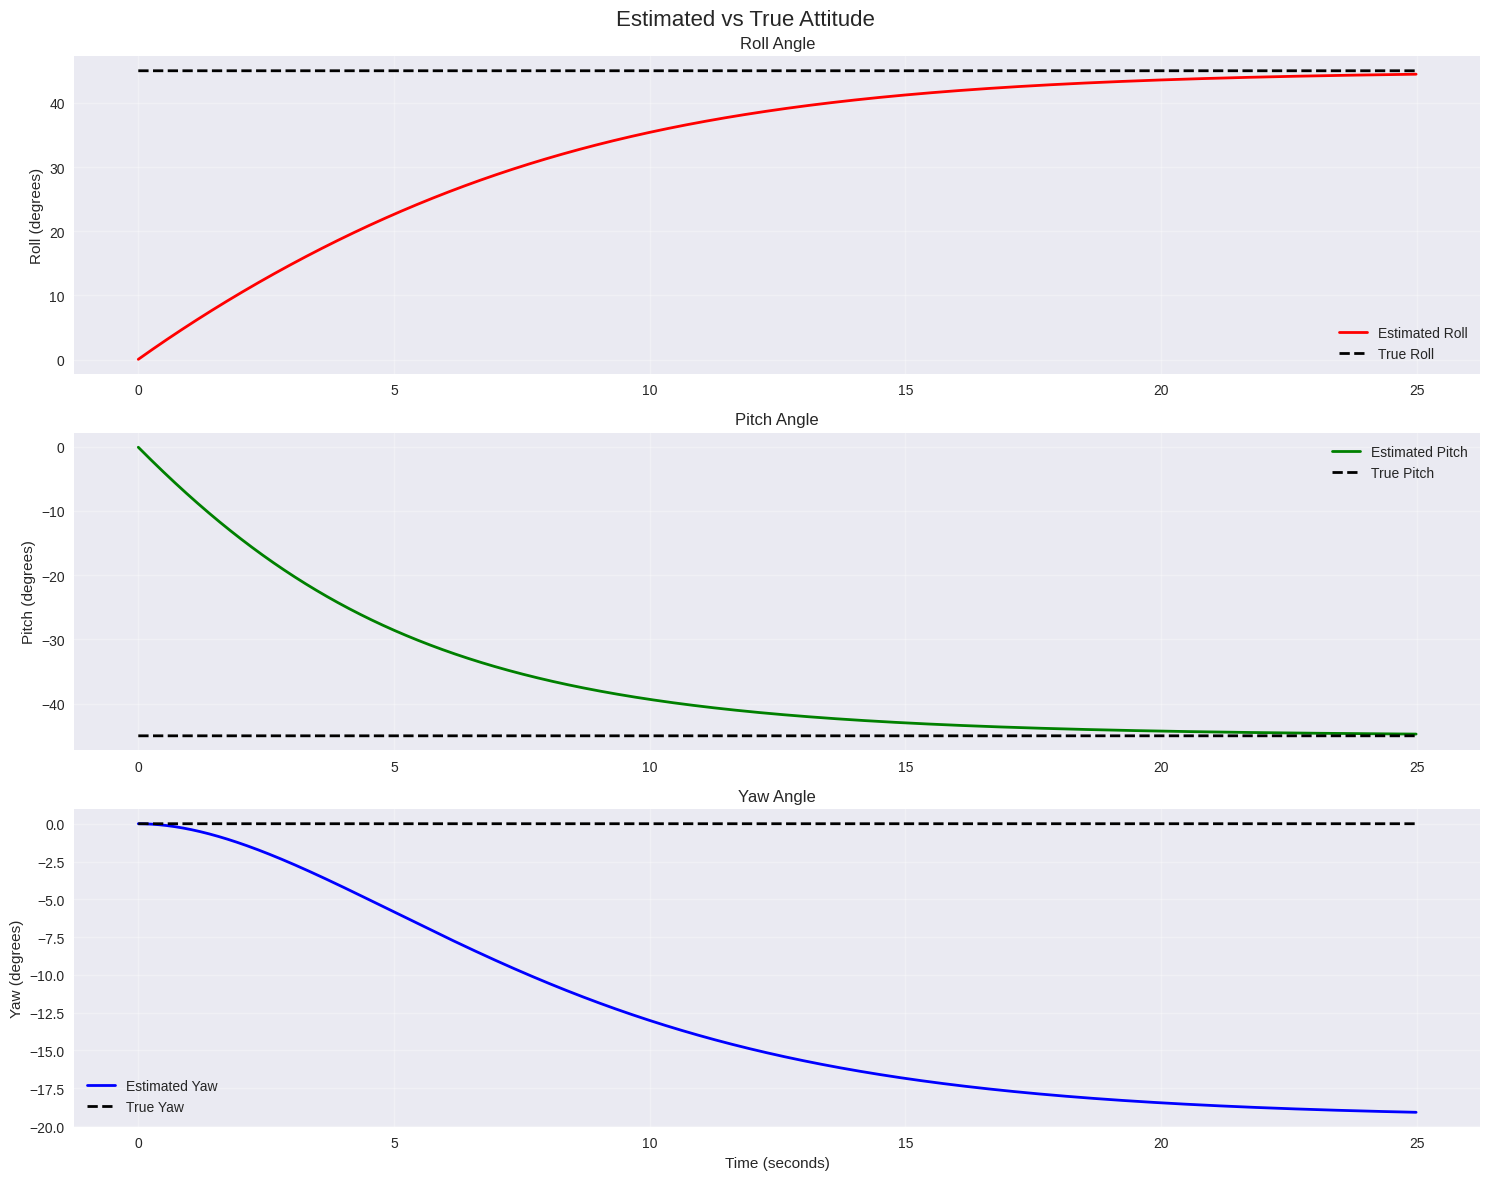

In [93]:
# Plot error analysis
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Attitude Estimation Errors vs True Attitude (Clean Data)', fontsize=16)

# Roll error
axes[0].plot(time_array, error_after[:, 0], 'r-', label='Roll Error', linewidth=2)
axes[0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[0].set_ylabel('Roll Error (degrees)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Roll Error')

# Pitch error
axes[1].plot(time_array, error_after[:, 1], 'g-', label='Pitch Error', linewidth=2)
axes[1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1].set_ylabel('Pitch Error (degrees)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_title('Pitch Error')

# Yaw error
axes[2].plot(time_array, error_after[:, 2], 'b-', label='Yaw Error', linewidth=2)
axes[2].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[2].set_ylabel('Yaw Error (degrees)')
axes[2].set_xlabel('Time (seconds)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_title('Yaw Error')
axes[2].set_ylim(-10, 10)

plt.tight_layout()
plt.show()

# Plot comparison between estimated and true attitudes
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Estimated vs True Attitude', fontsize=16)

# Roll comparison
axes[0].plot(time_array, euler[:, 0], 'r-', linewidth=2, label='Estimated Roll')
axes[0].plot(time_array, true_euler[:, 0], 'k--', linewidth=2, label='True Roll')
axes[0].set_ylabel('Roll (degrees)')
axes[0].set_title('Roll Angle')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Pitch comparison
axes[1].plot(time_array, euler[:, 1], 'g-', linewidth=2, label='Estimated Pitch')
axes[1].plot(time_array, true_euler[:, 1], 'k--', linewidth=2, label='True Pitch')
axes[1].set_ylabel('Pitch (degrees)')
axes[1].set_title('Pitch Angle')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Yaw comparison
axes[2].plot(time_array, euler[:, 2], 'b-', linewidth=2, label='Estimated Yaw')
axes[2].plot(time_array, true_euler[:, 2], 'k--', linewidth=2, label='True Yaw')
axes[2].set_ylabel('Yaw (degrees)')
axes[2].set_xlabel('Time (seconds)')
axes[2].set_title('Yaw Angle')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()
